# Notebook for Model Analysis 
This notebook is inteded to complement the medium article. 
The purpose is to assess the peformance of the finetuned models on the test data set.

Key: note that 0 is brand, 2 is male and 3 is female.

Date 06/03/2023

### Data Scientist: John Adeojo https://www.john-adeojo.com/
### Linked in: https://www.linkedin.com/in/john-adeojo/
### Medium: https://johnadeojo.medium.com/
### Hugging Face: https://huggingface.co/Johnade

In [1]:
import pandas as pd
import numpy as np

# Read in Training, Test and Validation data 

In [2]:
expanded_test = r"https://raw.githubusercontent.com/john-adeojo/Twitter-Transformer-Models/main/Data/expanded_test_df.csv"
expanded_train = r"https://raw.githubusercontent.com/john-adeojo/Twitter-Transformer-Models/main/Data/expanded_train_df.csv"
expanded_validation = r"https://raw.githubusercontent.com/john-adeojo/Twitter-Transformer-Models/main/Data/expanded_validation_df.csv"


expanded_train_df = pd.read_csv(expanded_train)
expanded_validation_df= pd.read_csv(expanded_validation)
expanded_test_df= pd.read_csv(expanded_test)

expanded_train_df["cat codes"] = expanded_train_df["gender"].astype("category").cat.codes
expanded_validation_df["cat codes"] = expanded_validation_df["gender"].astype("category").cat.codes
expanded_test_df["cat codes"] = expanded_test_df["gender"].astype("category").cat.codes

# Function for Running Inference

In [3]:
# Run inference
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
# from torch.utils.data import DataLoader, Dataset

# define a function to extract predicted and prob values
def extract_values(x):
    label = x['inference'][0]['label']
    predicted = int(label.split('_')[-1])
    prob = x['inference'][0]['score']
    return pd.Series({'predicted': predicted, 'prob': prob})



# Function for inference with fine tuned models
def perform_inference(df, MODEL, model_path):
    
    _df = df.copy()
    
    # load model
    model = AutoModelForSequenceClassification.from_pretrained(model_path)

    # Set up tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    
    # set up pipeline
    _classifier = pipeline("text-classification", model, tokenizer=tokenizer, device=0)
    
    # inference
    _df["inference"] = _df["general_twitter_text"].apply(lambda x: _classifier(str(x)))
    _df[['predicted', 'prob']] = _df.apply(extract_values, axis=1)
    _df['predicted'] = _df['predicted'].astype(int)
    


   
    return _df
    



In [4]:
def zero_shot_classification(df):
    
    _df = df.copy()
   

    # Define candidate labels
    candidate_labels = ["male", "female", "brand"]
    
    # Load the zero-shot classification pipeline
    classifier = pipeline(model="MoritzLaurer/multilingual-MiniLMv2-L6-mnli-xnli")

    # Perform classification on each input text
    results = []
    for text in _df["general_twitter_text"]:
        # Classify the text with the labels
        classification = classifier(str(text), candidate_labels)

        # Add the predicted label to the results list
        predicted_label = classification["labels"][0]
        results.append(predicted_label)
        
    # Merge the predicted label back onto the original DataFrame by index
    _df = _df.assign(predicted_label=results)
    
    # Keep only the predicted label column
    _df["predicted"] = _df["predicted_label"].astype("category").cat.codes
    
    return _df


# Run Inference

In [5]:
zero_shot = zero_shot_classification(expanded_test_df)

In [6]:
distilbert_df = perform_inference(df=expanded_test_df, 
                  MODEL="distilbert-base-multilingual-cased", 
                  model_path="Johnade/distilbert-base-multilingual-cased-twitter-identity-classification"
                 )

C:\Users\johna\anaconda3\envs\twitter-env-2\lib\site-packages\transformers\pipelines\base.py:1045: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [7]:
albert_df = perform_inference(df=expanded_test_df, 
                  MODEL="albert-base-v2", 
                  model_path="Johnade/albert-base-v2-fine-tune-twitter-identity-classification"
                 )

C:\Users\johna\anaconda3\envs\twitter-env-2\lib\site-packages\transformers\pipelines\base.py:1045: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


# Performance Assessment
## Key for labels: 

## 0 = brand
## 2 = male 
## 3 = female

In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def classification_metrics(df, title):
    y_true = df['cat codes']
    y_pred = df['predicted']
    labels = sorted(list(set(y_true)))
    
    # calculate metrics at the class level
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, labels=labels, average=None)
    
    # calculate macro-average metrics
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    
    # calculate overall accuracy
    accuracy = np.mean(y_true == y_pred)
    
    # print metrics at the class level
    print('Class level metrics:')
    metrics_dict = {'Precision': precision, 'Recall': recall, 'F1': f1, 'Support': support}
    metrics_df = pd.DataFrame(metrics_dict, index=labels)
    print(metrics_df)
    
    # print macro-average metrics
    print('\nMacro-average metrics:')
    print('Precision: {:.2f}'.format(macro_precision))
    print('Recall: {:.2f}'.format(macro_recall))
    print('F1: {:.2f}'.format(macro_f1))
    
    # print overall accuracy
    print('\nOverall accuracy: {:.2f}'.format(accuracy))
    
    # create confusion matrix heat map
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(title)
    # plt.savefig(r'C:\Users\johna\anaconda3\envs\twitter-env-2\Data\03 Reports\matrix_' + title + '.png')
    plt.show()


Class level metrics:
   Precision    Recall        F1  Support
0   0.368321  0.620180  0.462165     1556
1   0.479263  0.164557  0.244994     1896
2   0.335890  0.372871  0.353416     1644

Macro-average metrics:
Precision: 0.39
Recall: 0.39
F1: 0.35

Overall accuracy: 0.37


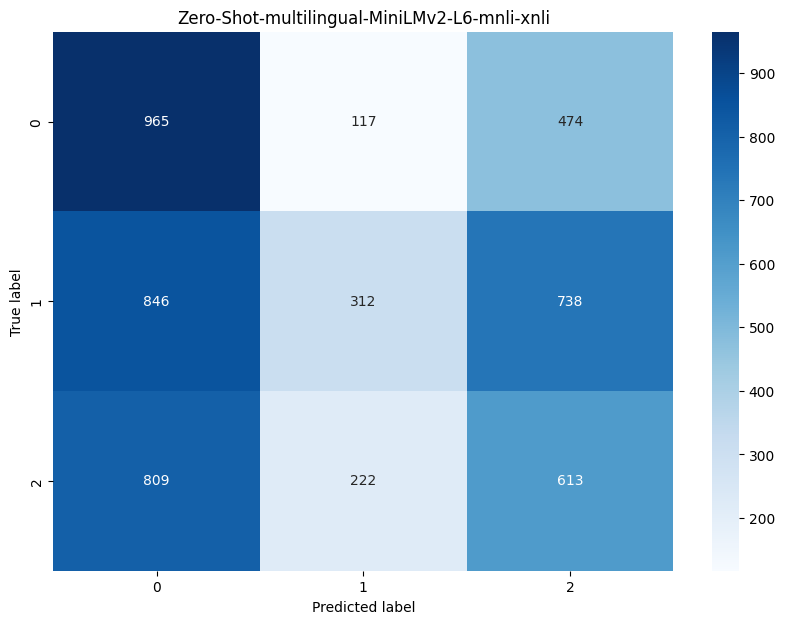

In [9]:
classification_metrics(zero_shot, title="Zero-Shot-multilingual-MiniLMv2-L6-mnli-xnli")

Class level metrics:
   Precision    Recall        F1  Support
0   0.661908  0.655527  0.658702     1556
1   0.619420  0.585443  0.601952     1896
2   0.509926  0.546837  0.527737     1644

Macro-average metrics:
Precision: 0.60
Recall: 0.60
F1: 0.60

Overall accuracy: 0.59


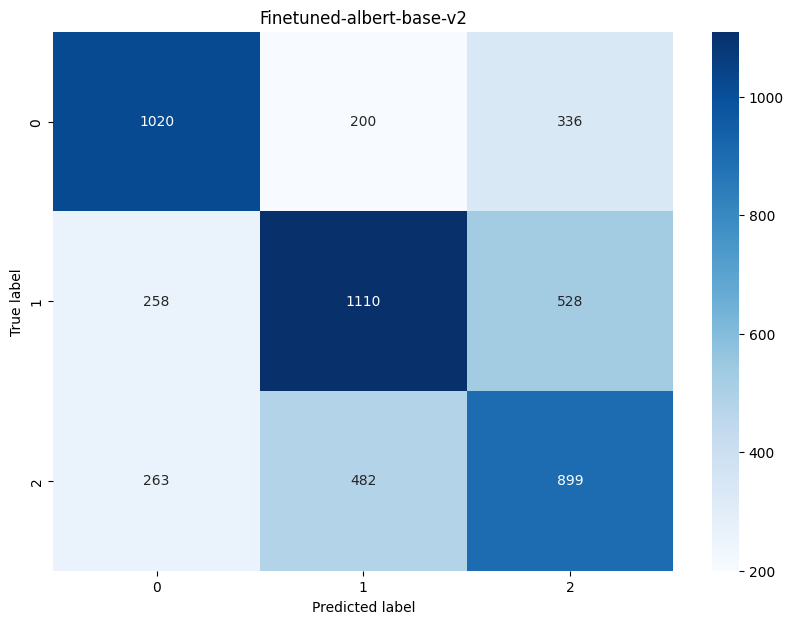

In [10]:
classification_metrics(albert_df, title="Finetuned-albert-base-v2")

Class level metrics:
   Precision    Recall        F1  Support
0   0.605456  0.741645  0.666667     1556
1   0.572316  0.680380  0.621687     1896
2   0.581197  0.330900  0.421705     1644

Macro-average metrics:
Precision: 0.59
Recall: 0.58
F1: 0.57

Overall accuracy: 0.59


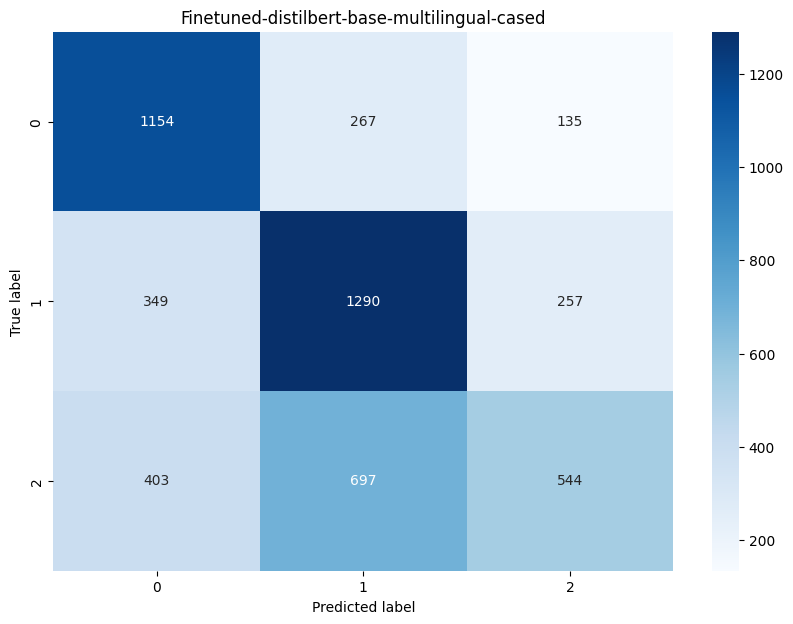

In [11]:
classification_metrics(distilbert_df, title="Finetuned-distilbert-base-multilingual-cased")

# Model Convergence Plots

In [12]:
import requests
import json

def load_json_file(url):
    response = requests.get(url)
    json_obj = json.loads(response.text)
    return json_obj



In [13]:
# distilbert
filepath = r"https://raw.githubusercontent.com/john-adeojo/Twitter-Transformer-Models/main/Model/distilbert-base-multilingual-cased-finetune-twitter/trainer_state.json"
distilbert_conv = load_json_file(filepath)

# albert
filepath = r"https://raw.githubusercontent.com/john-adeojo/Twitter-Transformer-Models/main/Model/albert-base-v2/trainer_state.json"
albert_conv = load_json_file(filepath)

In [14]:
def plot_eval_loss(json_obj, title):
    # Extract the data for the plot
    eval_loss = [entry['eval_loss'] for entry in json_obj['log_history'] if 'eval_loss' in entry]
    step = [entry['step'] for entry in json_obj['log_history'] if 'eval_loss' in entry]
    
    # Create the plot using Seaborn
    sns.set_style("darkgrid")
    plt.plot(step, eval_loss)
    plt.title(f'Evaluation Loss vs Step: {title}')
    plt.xlabel('Step')
    plt.ylabel('Evaluation Loss')
    # plt.savefig(r'C:\Users\johna\anaconda3\envs\twitter-env-2\Data\03 Reports\convergence_f' + title + '.png')
    plt.show()


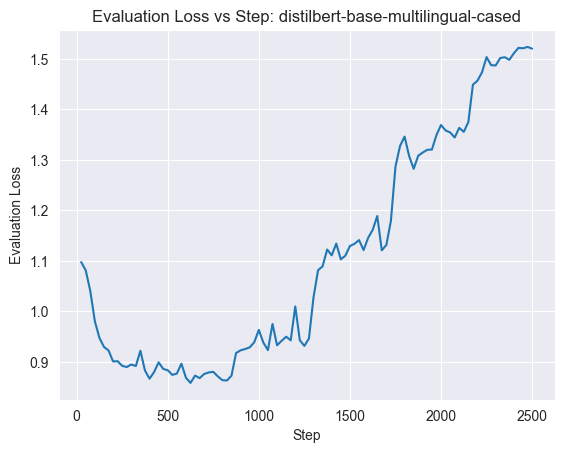

In [15]:
plot_eval_loss(distilbert_conv, title="distilbert-base-multilingual-cased")

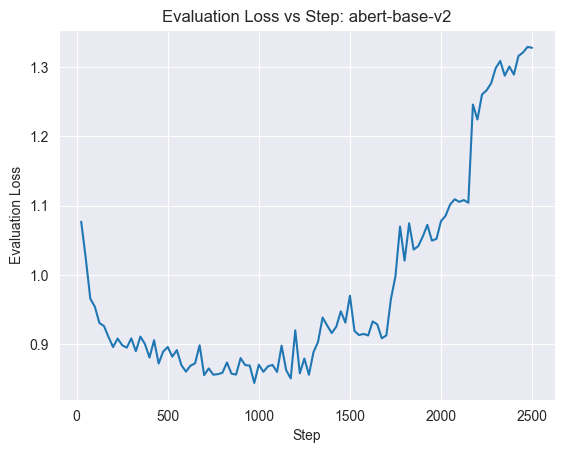

In [16]:
plot_eval_loss(albert_conv, title="abert-base-v2")